In [1]:
import pandas as pd
import json
import pickle
import numpy as np
import re
import joblib

In [2]:
import sys 
sys.path.append('../')
from fast_tsne.fast_tsne import fast_tsne

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sentence_transformers import SentenceTransformer

# Get sentence embedding
def get_embeddings(data, model_name='all-MiniLM-L6-v2', device='cpu', convert=True):
    print('Getting embeddings ...')
    smodel = SentenceTransformer(model_name, device=device)
    embeddings = smodel.encode(data, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

    if convert:
        x = embeddings.shape[0]
        embeddings = embeddings.reshape([x * 384, 1])
        embeddings = pd.DataFrame({'embed': embeddings[:, 0].cpu().numpy()})
        embeddings = embeddings.embed.to_numpy().reshape([x, 384])
    return (embeddings)

In [5]:
# Fixes extra spacing with apostrophes in text
def clean_text(text):
    if text:
        text = re.sub(r"\s?'\s?s", '', text)
        text = text.strip()
    return (text)

## Filter test clusters

### Use cluster results over entire factiva dataset

In [6]:
factiva_output ='../../data/factiva/'
gpt3_data_folder = '../../data/gpt3_train/'

### Clean clusters

In [7]:
test = pd.read_pickle('{}/clusters/first_nations_all_final_70.pkl'.format(factiva_output))

In [118]:
# Remove entities with Parliament/prime minister
result = test.copy()
result = result[~result.entity1.str.contains('Parliament', case=False)] 
result = result[~result.entity2.str.contains('Parliament', case=False)] 
result = result[~result.entity1.str.contains('prime minister|minister', case=False, regex=True)] 
result = result[~result.entity2.str.contains('prime minister|minister', case=False, regex=True)] 
result = result.sort_values(['k', 'dist'])

# fix apostrophes 
result.loc[:, 'entity1'] = result.entity1.apply(clean_text)
result.loc[:, 'entity2'] = result.entity2.apply(clean_text)
result.loc[:, 'narrative'] = '[' + result['entity1'] + '] (' + \
                                result['verb'] + ') [' + \
                                result['entity2'] + ']'

# remove enteries where entity1 = entity 2 = verb
result = result[result.entity1!=result.entity2]
result = result[result.entity1!=result.verb]
result = result[result.verb!=result.entity2]

In [ ]:
# filter only for specific clusters
## Create test dataset:
## Labels 24: climante change
## Labels 63: Indeginous people 
## Labels 18: Kevin rudd 
result = result[result.labels.isin([24, 63, 18])]

In [ ]:
# retrieve only sentences that are associated with 1 label (pure topics)
result = pd.merge(result, 
                  result[['text', 'labels']].drop_duplicates().\
                  groupby('text').size().reset_index(name='l'))
result = result[result.l == 1]
result = result.sort_values(['labels', 'dist'])

# remove where entity 1 is within entity 2 and vice versa
result['e1ine2'] = result.apply(lambda x:x['entity1'] in x['entity2'], axis=1)
result['e2ine1'] = result.apply(lambda x:x['entity2'] in x['entity1'], axis=1)
result = result[(result.e1ine2== False) & (result.e2ine1 == False)]
result = result.drop(columns = ['e1ine2', 'e2ine1']).reset_index(drop = True)

### Merge with true sentences

In [ ]:
# original sentences: true_text
# co-referenced sentences: text

In [8]:
orig_sent = pd.read_json('{}/temp/orig_sentences.jsonl'.format(factiva_output), 
                              lines=True)
orig_sent = orig_sent[['id', 'content']]
orig_sent = pd.concat([orig_sent.drop(columns ='content'), 
                       pd.DataFrame(orig_sent.content.tolist())], axis = 1)
orig_sent = orig_sent.explode(['sentences', 'sentences_idx'])

orig_sent['sentence_id'] = orig_sent.id + '_' + orig_sent.sentences_idx.astype(str)

orig_sent = orig_sent[['sentence_id', 'sentences']].\
    rename(columns={'sentences':'true_text'}) 

In [82]:
test_data = result[['sentence_id', 'text', 'dist', 'labels', 'embeddings']].\
    rename(columns={'labels':'true_labels'})

test_data = pd.merge(orig_sent, test_data)

In [85]:
test_data.shape

(11780, 6)

In [87]:
test_data.groupby(['true_labels']).size()

true_labels
18    3994
24    1987
63    5799
dtype: int64

In [187]:
test_data.to_pickle('{}/temp/cluster_test_data.pkl'.format(factiva_output))

### Sample sentences for GPT3 fine-tuned model

In [25]:
test_data = pd.read_pickle('{}/temp/cluster_test_data.pkl'.format(factiva_output))
test_data = test_data.drop(columns={'embeddings'}, errors='ignore').reset_index(drop = True)

In [26]:
# Clean data
# Clean quotes in the original sentences and co-referenced sentences

test_data.loc[:, 'true_text'] = test_data.true_text.str.replace('&quot', '')
test_data.loc[:, 'text'] = test_data.text.str.replace('& quot', '')

# Remove extra quotes
test_data['check'] = test_data.true_text.str.count('"')
test_data.loc[test_data.check.isin([1, 3]), 'true_text'] = \
test_data[test_data.check.isin([1, 3])].true_text.str.replace('"', '')

test_data['check'] = test_data.text.str.count('"')
test_data.loc[test_data.check.isin([1, 3]), 'text'] = \
test_data[test_data.check.isin([1, 3])].text.str.replace('"', '')

# Remove duplicates
test_data = test_data.groupby(['true_labels', 'text']).head(1)
test_data = test_data.drop(columns = 'check').reset_index(drop = True)

In [27]:
test_data.index

RangeIndex(start=0, stop=8199, step=1)

In [131]:
embeddings = get_embeddings(test_data.text.tolist())
embeddings = pd.DataFrame({'embeddings':list(embeddings)})
test_data = pd.concat([test_data, embeddings], axis = 1)

Getting embeddings ...


Batches: 100%|████████████████████████████████████████████████████████████████████| 129/129 [00:12<00:00, 10.74it/s]


In [ ]:
len(embeddings)

8199

In [134]:
test_data.shape

(8199, 6)

In [153]:
test_data.groupby('true_labels').size()

true_labels
18    2553
24    1472
63    4174
dtype: int64

### Sample closets sentences to centroid from clusters

In [ ]:
test_sample = test_data.sort_values(['true_labels', 'dist']).groupby(['true_labels']).head(1000)
# test_sample = test_data.groupby(['true_labels']).sample(n=1000, random_state=3005)
test_sample = test_sample.groupby(['true_labels', 'text']).head(1).reset_index(drop = True)

### Plot embeddings

In [74]:
col = {'18':'#abd9e9',
'24':'#fdae61',
'63': '#D2AB3C'}

## Create test dataset:
## Labels 16: climante change (mapping: labels 24)
## Labels 37: Indeginous people (mapping: labels 63, 17 (aboriginal))
## Labels 21: Kevin rudd (mapping: labels 18)

true_labels = {18:'Kevin rudd',
24:'Climate change',
63:'Indeginous people'}

In [ ]:
%time Z2 = fast_tsne(test_sample.embeddings.tolist())
Z2 = pd.DataFrame({'x': Z2[:,0], 'y':Z2[:,1], 'label':test_sample.true_labels.tolist()})

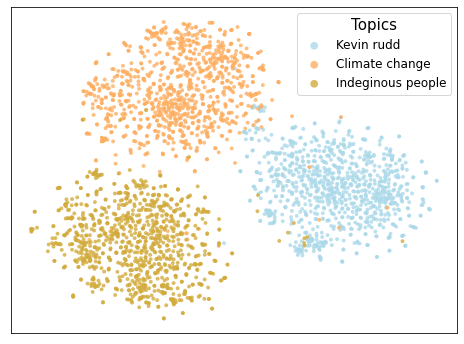

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
for label in Z2.label.unique():
    ax.scatter(Z2[Z2.label == label].x.tolist(), 
               Z2[Z2.label == label].y.tolist(), 
               c=[col[str(i)] for i in Z2[Z2.label == label].label.tolist()], 
               s=15, label=true_labels[label],
               alpha=0.8, edgecolors='none')

ax.legend(title='Topics', loc=1, prop={'size': 12}, 
          title_fontsize=15, markerscale=2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig('test_clusters_samples.png'.format(), bbox_inches='tight')

In [84]:
test_sample.\
    drop(columns = ['embeddings']).\
    to_json('{}/test_data_samples.jsonl'.format(gpt3_data_folder), lines = True, orient='records')

### Remove train ids from test

In [172]:
train_data = pd.read_json('{}/train_data_samples_ids.jsonl'.format(gpt3_data_folder),
                     lines = True, orient='records')

In [439]:
# test_data_closest
test_sample = pd.read_json('{}/test_data_samples.jsonl'.format(gpt3_data_folder), 
                          lines = True, orient='records')
# test_data2 = pd.read_json('similar_sentences/test_data_samples.jsonl', lines = True, orient='records')

In [15]:
ids = train_data.main_id.tolist()
ids.extend(train_data.matching_id.tolist())

In [16]:
remove_ids = np.unique([i for i in ids if i in test_sample.sentence_id.tolist()])

In [17]:
len(remove_ids) # 90

0

In [171]:
test_sample = test_sample[~test_sample.sentence_id.isin(remove_ids)]
test_sample.to_json('{}/test_data_samples.jsonl'.format(gpt3_data_folder), 
                    lines = True, orient='records')

In [173]:
test_sample.groupby('true_labels').size()

true_labels
18    992
24    982
63    936
dtype: int64

In [20]:
len(remove_ids)

69

### Sample noise

In [ ]:
np.random.seed(3005)

# Remove selected labels 24, 63, 18
noise = test[~test.labels.isin([24, 63, 18])]
noise = noise[['sentence_id', 'text', 'dist', 'labels']].\
    rename(columns={'labels':'true_labels'})

noise = pd.merge(orig_sent, noise)
noise = noise.groupby(['text']).head(1)
noise = noise.reset_index(drop = True)

# random sample 5000 sentences as noise
noise = noise.sort_values(['true_labels', 'dist']).\
            groupby(['true_labels']).\
            tail(100).\
            sample(5000, random_state=3005).\
            reset_index(drop = True)
            
noise.loc[:, 'true_labels'] = 1

In [396]:
ids = train_data.main_id.tolist()
ids.extend(train_data.matching_id.tolist())
remove_ids = np.unique([i for i in ids if i in noise.sentence_id.tolist()])

In [397]:
noise = noise[~noise.sentence_id.isin(remove_ids)]

In [398]:
noise.shape

(4952, 5)

In [399]:
noise = noise[~noise.sentence_id.isin(test_sample.sentence_id)]

In [400]:
noise.shape

(4950, 5)

In [401]:
noise.to_json('{}/test_data_selected_noise.jsonl'.format(gpt3_data_folder), 
              lines = True, orient='records')

### Plot clusters

In [402]:
temp = pd.concat([test_sample[['sentence_id', 'text','true_labels']].reset_index(drop = True),
                 noise[['sentence_id', 'text','true_labels']].reset_index(drop = True)], 
            axis = 0)
temp = temp.reset_index(drop = True)

In [403]:
embeddings = get_embeddings(temp.text.tolist())
embeddings = pd.DataFrame({'embeddings':list(embeddings)})
temp = pd.concat([temp, embeddings], axis = 1)

Getting embeddings ...


Batches:   0%|          | 0/123 [00:00<?, ?it/s]

In [404]:
%time Z1 = fast_tsne(temp.embeddings.tolist())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2022-06-08 13:27:03.758361-427705081.dat
fast_tsne result_path: result_2022-06-08 13:27:03.758361-427705081.dat
fast_tsne nthreads: 16
Read the following parameters:
	 n 7860 by d 384 dataset, theta 0.500000,
	 perplexity 30.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 655.000000, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 4500,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, int

In [405]:
col = {'18':'#abd9e9',
'24':'#fdae61',
'63': '#D2AB3C',
'1': '#808080'}

## Create test dataset:
## Labels 16: climante change 
## Labels 37: Indeginous people 
## Labels 21: Kevin rudd 

true_labels = {18:'Kevin rudd',
24:'Climate change',
63:'Indeginous people',
1: 'Noise'}

In [406]:
Z1 = pd.DataFrame({'x': Z1[:,0], 'y':Z1[:,1], 'label':temp.true_labels.tolist()})

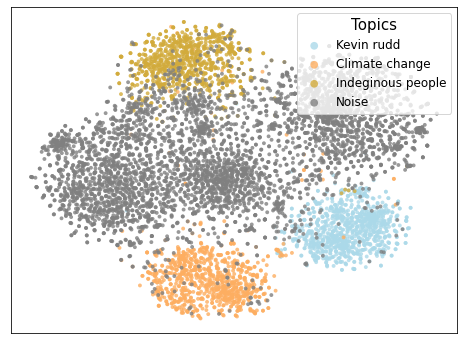

In [414]:


fig, ax = plt.subplots(figsize=(8,6))
for label in Z1.label.unique():
    ax.scatter(Z1[Z1.label == label].x.tolist(), 
               Z1[Z1.label == label].y.tolist(), 
               c=[col[str(i)] for i in Z1[Z1.label == label].label.tolist()], 
               s=15, label=true_labels[label],
               alpha=0.8, edgecolors='none')

ax.legend(title='Topics', loc=1, prop={'size': 12}, 
          title_fontsize=15, markerscale=2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig('pics/test_clusters_noise.png', bbox_inches='tight')